In [1]:
import os
import torch
from torch_geometric.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
import pandas as pd
import numpy as np
import Kamal_graph as k

In [2]:
def sample_tpm_rows_binary(dataframe, percentage_zero_tpm):
    """
    Randomly samples rows from the dataframe with all rows having TPM > 0
    and X% of rows with TPM = 0.

    Parameters:
    - dataframe (pd.DataFrame): The input dataframe containing a 'TPM' column.
    - percentage_zero_tpm (float): The percentage of rows with TPM = 0 to sample (0 to 100).

    Returns:
    - pd.DataFrame: A dataframe containing the sampled rows.
    """
    # Split the dataframe into two groups
    non_zero_tpm = dataframe[dataframe['TPM'] > 10]
    zero_tpm = dataframe[dataframe['TPM'] <= 10]
    
    # Calculate the number of rows to sample from zero TPM group
    num_zero_tpm_to_sample = int(len(non_zero_tpm) / (1- (percentage_zero_tpm / 100)) * (percentage_zero_tpm / 100))
    
    # Sample the zero TPM rows
    sampled_zero_tpm = zero_tpm.sample(n=num_zero_tpm_to_sample, random_state=42)
    
    # Concatenate all rows with TPM > 0 and the sampled zero TPM rows
    sampled_df = pd.concat([non_zero_tpm, sampled_zero_tpm])
    
    # Shuffle the final dataframe for randomness
    sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return sampled_df

rnaseq = pd.read_csv(
    '/Users/xxc15/Desktop/CS224W/project/data/ENCFF103FSL.tsv', sep="\t", header=0
)
rnaseq['gene_id'] = rnaseq['gene_id'].apply(lambda x: x.split('.')[0])
rnaseq = sample_tpm_rows_binary(rnaseq, 50)
# Create a mapping from gene_id to tpm
gene_id_to_tpm = dict(zip(rnaseq['gene_id'], rnaseq['TPM']))

In [3]:
# Directory where the graphs are saved
graph_dir = '/Users/xxc15/Desktop/CS224W/project/graphs_visual'

In [4]:
class GeneExpressionDataset(Dataset):
    def __init__(self, root, gene_id_to_tpm, transform=None, pre_transform=None):
        self.gene_id_to_tpm = gene_id_to_tpm
        super(GeneExpressionDataset, self).__init__(root, transform, pre_transform)
        
        # Only include graph files whose gene_id is in gene_id_to_tpm
        all_graph_files = [f for f in os.listdir(self.root) if f.endswith('.pt')]
        self.graph_files = []
        for graph_file in all_graph_files:
            graph_path = os.path.join(self.root, graph_file)
            data = torch.load(graph_path)
            gene_id = data.gene_id
            if gene_id in self.gene_id_to_tpm:
                # Check if the graph has at least 5 nodes
                if data.num_nodes >= 5:
                    self.graph_files.append(graph_file)
        self.graph_files.sort()  # Ensure consistent ordering

    def len(self):
        return len(self.graph_files)

    def get(self, idx):
        # Load the graph data object
        graph_path = os.path.join(self.root, self.graph_files[idx])
        data = torch.load(graph_path)
        
        # Get the gene_id from the data object
        gene_id = data.gene_id
        
        # Binary label: 0 if TPM < 10, 1 if TPM >= 10
        tpm_value = self.gene_id_to_tpm[gene_id]
        label = 1 if tpm_value > 10 else 0
        
        data.y = torch.tensor([label], dtype=torch.float)  # Binary label as a float
        data.gene_id = [gene_id]
        # print(f"Gene ID: {gene_id}, TPM: {tpm_value}, Label: {label}")
        
        return data



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GATClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, heads=4, dropout=0.2):
        super(GATClassifier, self).__init__()
        self.dropout = dropout
        self.convs = nn.ModuleList()
        
        # First GAT layer
        self.convs.append(GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=dropout))
        
        # Additional GAT layers
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True, dropout=dropout))
        
        # Final fully connected layer for classification
        self.fc = nn.Linear(hidden_dim * heads, output_dim)
        
        # Activation function
        self.activation = nn.ELU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            # print(f"Layer {i + 1} node embeddings (mean):", x.mean(dim=0))
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Global mean pooling
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer (logits)
        out = self.fc(x)
        return out.squeeze()


In [6]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

# Initialize the dataset
dataset = GeneExpressionDataset(root=graph_dir, gene_id_to_tpm=gene_id_to_tpm)

# Create indices for all samples
all_indices = list(range(len(dataset)))

# First split: Train (40%) and Temp (60%)
train_size = 0.4
temp_size = 0.6  # Remaining after train
train_indices, temp_indices = train_test_split(
    all_indices, test_size=temp_size, random_state=42
)

# Second split: Validation (50% of temp) and Test (50% of temp)
# Since temp_size is 60%, splitting it equally gives 30% each for val and test
val_size = 0.5
val_indices, test_indices = train_test_split(
    temp_indices, test_size=val_size, random_state=42
)

# Create subsets
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Get the input dimension from the dataset
sample_data = dataset[0]
input_dim = sample_data.num_node_features

# Initialize the model, loss function, and optimizer
model = GATClassifier(input_dim=input_dim, hidden_dim=128, output_dim=1, num_layers=2, heads=4)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)



/var/folders/6b/y4bf77dj2d5cnwkmbn6yqv_c0000gn/T/ipykernel_52371/3889566633.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_path)
/opt/miniconda

In [7]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        logits = model(data)
        y = data.y
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            logits = model(data)
            y = data.y
            loss = criterion(logits, y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_with_metrics(model, loader):
    model.eval()
    preds = []
    targets = []
    gene_ids = []
    with torch.no_grad():
        for data in loader:
            logits = model(data)
            # Apply sigmoid to get probabilities
            prob = torch.sigmoid(logits)
            # Binary predictions
            predicted = (prob >= 0.5).float().cpu().numpy()
            y_true = data.y.cpu().numpy()

            preds.extend(predicted)
            targets.extend(y_true)
            gene_ids.extend(data.gene_id)

    # Convert to int to ensure classification metrics interpret them as class labels
    preds_int = np.array(preds, dtype=int)
    targets_int = np.array(targets, dtype=int)

    acc = accuracy_score(targets_int, preds_int)
    f1 = f1_score(targets_int, preds_int, zero_division=0)
    precision = precision_score(targets_int, preds_int, zero_division=0)

    return preds_int, targets_int, gene_ids, acc, f1, precision


/var/folders/6b/y4bf77dj2d5cnwkmbn6yqv_c0000gn/T/ipykernel_52371/3889566633.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_path)


Early stopping!


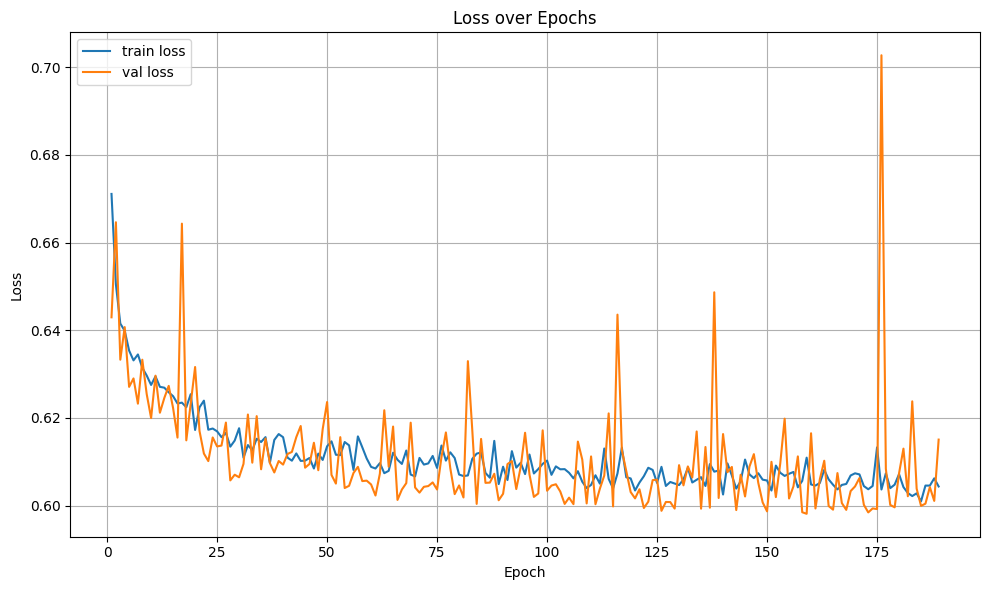

/var/folders/6b/y4bf77dj2d5cnwkmbn6yqv_c0000gn/T/ipykernel_52371/2147106253.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

<All keys matched successfully>

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 300
best_val_loss = float('inf')
patience = 30
patience_counter = 0
counter = 0

acc_list = []
f1_list = []
precision_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)
    
    # preds_int, targets_int, gene_ids, acc, f1, precision = evaluate_with_metrics(model, test_loader)
    
    # Store metrics
    # acc_list.append(acc)
    # f1_list.append(f1)
    # precision_list.append(precision)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    counter += 1

    # print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
    #       f'Acc: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping!')
            break

# Once training is complete or early stopped, plot the metrics over epochs
epochs = range(1, counter+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_list, label='train loss')
plt.plot(epochs, val_loss_list, label='val loss')
# plt.plot(epochs, f1_list, label='F1-Score')
# plt.plot(epochs, precision_list, label='Precision')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))


In [9]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))


# Evaluate on the test set
preds, targets, gene_ids, acc, f1, precision = evaluate_with_metrics(model, test_loader)
print(f'Test Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}')

results_df = pd.DataFrame({
    'gene_id': gene_ids,
    'label_actual': targets,
    'label_predicted': preds
})

# Save to CSV
results_df.to_csv('gene_predictions_binary.csv', index=False)
print('Binary classification predictions saved to gene_predictions_binary.csv')


/var/folders/6b/y4bf77dj2d5cnwkmbn6yqv_c0000gn/T/ipykernel_52371/1283142714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Test Accuracy: 0.6875, F1: 0.7382, Precision: 0.6706
Binary classification predictions saved to gene_predictions_binary.csv
